# Load

In [5]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid
from scipy.sparse import hstack, csr_matrix

np.random.seed(123)

train_data = pd.read_csv(r'../dataset/train-10m.csv')
valid_data = pd.read_csv(r'../dataset/valid.csv')
test_data = pd.read_csv(r'../dataset/test.csv')


In [6]:
# create sparse matrix
start_time = time.time()
all_data = pd.concat([train_data, valid_data, test_data])
dv = DictVectorizer(sparse=True)
X_train_valid_test = dv.fit_transform(all_data.drop(columns=['dep_delayed_15min']).to_dict(orient='records'))
n1, n2, n3 = len(train_data), len(valid_data), len(test_data)
X_train = X_train_valid_test[:n1]
X_valid = X_train_valid_test[n1:n1+n2]
X_test = X_train_valid_test[n1+n2:n1+n2+n3]
print(f"Time to create sparse matrices: {time.time() - start_time:.2f} seconds")
print(f"X_train shape: {X_train.shape}")

Time to create sparse matrices: 89.51 seconds
X_train shape: (10000000, 699)


# xgb_exa

In [13]:

dxgb_train = xgb.DMatrix(data=X_train, label=(train_data['dep_delayed_15min'] == 'Y').astype(int))
dxgb_valid = xgb.DMatrix(data=X_valid, label=(valid_data['dep_delayed_15min'] == 'Y').astype(int))
dxgb_test = xgb.DMatrix(data=X_test, label=(test_data['dep_delayed_15min'] == 'Y').astype(int))


params = {
    'max_depth': [12],
    'eta': [ 0.1],
    'min_child_weight': [1000],
    'subsample': [1]
}
param_grid = ParameterGrid(params)




In [5]:
for prm in param_grid:
    print(prm)
    start_time = time.time()
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=1000,
        max_depth=prm['max_depth'],
        learning_rate=prm['eta'],
        min_child_weight=prm['min_child_weight'],
        subsample=prm['subsample'],
        n_jobs=-1,  
        eval_metric='auc',
        early_stopping_rounds=100,
        tree_method='exact',
        gamma=60 #min_split_gain
    )
    model.fit(
        X_train, (train_data['dep_delayed_15min'] == 'Y').astype(int),
        eval_set=[(X_valid, (valid_data['dep_delayed_15min'] == 'Y').astype(int))],
        verbose=1
    )
    print(f"Time to train model: {time.time() - start_time:.2f} seconds")




{'eta': 0.1, 'max_depth': 12, 'min_child_weight': 1000, 'subsample': 1}
[0]	validation_0-auc:0.71194
[1]	validation_0-auc:0.71632
[2]	validation_0-auc:0.71811
[3]	validation_0-auc:0.71913
[4]	validation_0-auc:0.72077
[5]	validation_0-auc:0.72174
[6]	validation_0-auc:0.72257
[7]	validation_0-auc:0.72419
[8]	validation_0-auc:0.72461
[9]	validation_0-auc:0.72496
[10]	validation_0-auc:0.72537
[11]	validation_0-auc:0.72620
[12]	validation_0-auc:0.72686
[13]	validation_0-auc:0.72723
[14]	validation_0-auc:0.72780
[15]	validation_0-auc:0.72855
[16]	validation_0-auc:0.72923
[17]	validation_0-auc:0.72951
[18]	validation_0-auc:0.73004
[19]	validation_0-auc:0.73051
[20]	validation_0-auc:0.73091
[21]	validation_0-auc:0.73127
[22]	validation_0-auc:0.73192
[23]	validation_0-auc:0.73226
[24]	validation_0-auc:0.73238
[25]	validation_0-auc:0.73258
[26]	validation_0-auc:0.73303
[27]	validation_0-auc:0.73325
[28]	validation_0-auc:0.73374
[29]	validation_0-auc:0.73398
[30]	validation_0-auc:0.73408
[31]	val

In [7]:
# save model
model.save_model('xgb_exa.json')

In [7]:
start_time = time.time()
model = xgb.XGBClassifier()
model.load_model('xgb_exa.json')

phat = model.predict_proba(X_test)[:, 1]
print(f"Time to predict: {time.time() - start_time:.2f} seconds")


auc = roc_auc_score((test_data['dep_delayed_15min'] == 'Y').astype(int), phat)
print(f"Test AUC: {auc:.4f}")

acc=(phat>0.5)==(test_data['dep_delayed_15min'] == 'Y')
print(f"Test accuracy: {acc.mean():.4f}")

Time to predict: 0.62 seconds
Test AUC: 0.7493
Test accuracy: 0.8019


# xgb_his

In [39]:
for prm in param_grid:
    print(prm)
    start_time = time.time()
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=1000,
        # max_depth=prm['max_depth'],
        learning_rate=prm['eta'],
        min_child_weight=prm['min_child_weight'],
        subsample=prm['subsample'],
        n_jobs=-1,  
        eval_metric='auc',
        early_stopping_rounds=100,
        tree_method='hist',
        max_leaves=255

    )
    model.fit(
        X_train, (train_data['dep_delayed_15min'] == 'Y').astype(int),
        eval_set=[(X_valid, (valid_data['dep_delayed_15min'] == 'Y').astype(int))],
        verbose=1
    )
    print(f"Time to train model: {time.time() - start_time:.2f} seconds")



{'eta': 0.1, 'max_depth': 12, 'min_child_weight': 1000, 'subsample': 1}
[0]	validation_0-auc:0.69729
[1]	validation_0-auc:0.70030
[2]	validation_0-auc:0.70194
[3]	validation_0-auc:0.70323
[4]	validation_0-auc:0.70456
[5]	validation_0-auc:0.70518
[6]	validation_0-auc:0.70638
[7]	validation_0-auc:0.70742
[8]	validation_0-auc:0.70809
[9]	validation_0-auc:0.70814
[10]	validation_0-auc:0.70936
[11]	validation_0-auc:0.71015
[12]	validation_0-auc:0.71040
[13]	validation_0-auc:0.71081
[14]	validation_0-auc:0.71105
[15]	validation_0-auc:0.71173
[16]	validation_0-auc:0.71229
[17]	validation_0-auc:0.71297
[18]	validation_0-auc:0.71327
[19]	validation_0-auc:0.71362
[20]	validation_0-auc:0.71424
[21]	validation_0-auc:0.71491
[22]	validation_0-auc:0.71558


KeyboardInterrupt: 

In [15]:
model.save_model('xgb_hist.json')


In [8]:
start_time = time.time()
model = xgb.XGBClassifier()
model.load_model('xgb_hist.json')

phat = model.predict_proba(X_test)[:, 1]
print(f"Time to predict: {time.time() - start_time:.2f} seconds")


auc = roc_auc_score((test_data['dep_delayed_15min'] == 'Y').astype(int), phat)
print(f"Test AUC: {auc:.4f}")

acc=(phat>0.5)==(test_data['dep_delayed_15min'] == 'Y')
print(f"Test accuracy: {acc.mean():.4f}")

Time to predict: 0.37 seconds
Test AUC: 0.7469
Test accuracy: 0.8008


# lgb_base

In [18]:
import lightgbm as lgb

X_train_lgb = lgb.Dataset(X_train, label=(train_data['dep_delayed_15min'] == 'Y').astype(int), params={'enable_bundle': False})
X_valid_lgb = lgb.Dataset(X_train, label=(train_data['dep_delayed_15min'] == 'Y').astype(int), params={'enable_bundle': False})
X_test_lgb = lgb.Dataset(X_train, label=(train_data['dep_delayed_15min'] == 'Y').astype(int), params={'enable_bundle': False})

X_train_lgb_b = lgb.Dataset(X_train, label=(train_data['dep_delayed_15min'] == 'Y').astype(int), params={'enable_bundle': True})
X_valid_lgb_b = lgb.Dataset(X_train, label=(train_data['dep_delayed_15min'] == 'Y').astype(int), params={'enable_bundle': True})
X_test_lgb_b = lgb.Dataset(X_train, label=(train_data['dep_delayed_15min'] == 'Y').astype(int), params={'enable_bundle': True})


In [ ]:
# lgb_base

for prm in param_grid:
    print(prm)
    start_time = time.time()
    model=lgb.train(
        params={
            'objective': 'binary',
            'metric': 'auc',
            'num_leaves': 255,
            'learning_rate': prm['eta'],
            'min_child_weight': prm['min_child_weight'],
            'subsample': prm['subsample'],
            'n_jobs': -1,
            'enable_bundle': False,
            # 'boosting_type': 'goss',

            # 'top_rate':0.1,
            # 'other_rate':0.1
            
            
        },
        train_set=X_train_lgb,
        num_boost_round=1000,
        valid_sets=[X_valid_lgb],
        callbacks=[lgb.log_evaluation(period=1)]
    
    )

    
    print(f"Time to train model: {time.time() - start_time:.2f} seconds")



{'eta': 0.1, 'max_depth': 12, 'min_child_weight': 1000, 'subsample': 1}
[LightGBM] [Info] Number of positive: 1927360, number of negative: 8072640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.043391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 10000000, number of used features: 656
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192736 -> initscore=-1.432329
[LightGBM] [Info] Start training from score -1.432329
[1]	valid_0's auc: 0.723842
[2]	valid_0's auc: 0.72951
[3]	valid_0's auc: 0.731442
[4]	valid_0's auc: 0.73271
[5]	valid_0's auc: 0.734091
[6]	valid_0's auc: 0.735052
[7]	valid_0's auc: 0.736583
[8]	valid_0's auc: 0.738224
[9]	valid_0's auc: 0.739273
[10]	valid_0's auc: 0.740788
[11]	valid_0's auc: 0.741931
[12]	valid_0's auc: 0.74271
[13]	valid_0's auc: 0.7439

In [21]:
model.save_model('lgb_base.json')

In [ ]:
model=lgb.Booster(model_file='lgb_base.json')
phat = model.predict(X_test)

auc = roc_auc_score((test_data['dep_delayed_15min'] == 'Y').astype(int), phat)
print(f"Test AUC: {auc:.4f}")


Time to predict: 2086.77 seconds
Test AUC: 0.7720
Test accuracy: 0.8064


# lgb_EFB_only

In [32]:

for prm in param_grid:
    print(prm)
    start_time = time.time()
    model=lgb.train(
        params={
            'objective': 'binary',
            'metric': 'auc',
            'num_leaves': 255,
            'learning_rate': prm['eta'],
            'min_child_weight': prm['min_child_weight'],
            'subsample': prm['subsample'],
            'n_jobs': -1,
            'enable_bundle':True,
            # 'boosting_type': 'goss',

            # 'top_rate':0.1,
            # 'other_rate':0.1
            
            
        },
        train_set=X_train_lgb_b,
        num_boost_round=1000,
        valid_sets=[X_valid_lgb_b],
        callbacks=[lgb.log_evaluation(period=1)]
    
    )

    
    print(f"Time to train model: {time.time() - start_time:.2f} seconds")


{'eta': 0.1, 'max_depth': 12, 'min_child_weight': 1000, 'subsample': 1}
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 1927360, number of negative: 8072640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 10000000, number of used features: 656
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192736 -> initscore=

In [33]:
model.save_model('lgb_efb.json')

In [34]:
model=lgb.Booster(model_file='lgb_efb.json')
phat = model.predict(X_test)

auc = roc_auc_score((test_data['dep_delayed_15min'] == 'Y').astype(int), phat)
print(f"Test AUC: {auc:.4f}")

acc=(phat>0.5)==(test_data['dep_delayed_15min'] == 'Y')

print(f"Test accuracy: {acc.mean():.4f}")

Test AUC: 0.7720
Test accuracy: 0.8064




# lgbm

In [37]:
# GOSS

for prm in param_grid:
    print(prm)
    start_time = time.time()
    model=lgb.train(
        params={
            'objective': 'binary',
            'metric': 'auc',
            'num_leaves': 255,
            'learning_rate': prm['eta'],
            'min_child_weight': prm['min_child_weight'],
            'subsample': prm['subsample'],
            'n_jobs': -1,
            'enable_bundle': True,
            'boosting_type': 'goss',
            'top_rate':0.1,
            'other_rate':0.1
            
            
        },
        train_set=X_train_lgb_b,
        num_boost_round=1000,
        valid_sets=[X_valid_lgb_b],
        callbacks=[lgb.log_evaluation(period=1)]
    
    )

    
    print(f"Time to train model: {time.time() - start_time:.2f} seconds")


{'eta': 0.1, 'max_depth': 12, 'min_child_weight': 1000, 'subsample': 1}
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reason

KeyboardInterrupt: 

In [26]:
model.save_model('lgb_goss.json')

In [35]:
model=lgb.Booster(model_file='lgb_goss.json')
phat = model.predict(X_test)

auc = roc_auc_score((test_data['dep_delayed_15min'] == 'Y').astype(int), phat)

print(f"Test AUC: {auc:.4f}")


Test AUC: 0.7684


In [2]:
def parse_log():
    fns=[f"log_{i}.log" for i in range(5)]
    data=[]
    for fn in fns:
        timestamps=[]
        auc=[]
        with open(fn) as f:
            lines=f.readlines()
            for i,line in enumerate(lines):
                if 'auc' in line:
                    timestamps.append(float(len(timestamps)+1))
                    auc_pos=line.find('auc')
                    auc.append(float(line[auc_pos+4:auc_pos+10]))
                if i==len(lines)-1:
                    time_pos=line.find(':')
                    time_pos_end=line.find('seconds')
                    time_per_iter=float(line[time_pos+1:time_pos_end])
                    if fn=='log_0.log':
                        time_per_iter/=431
                    else:
                        time_per_iter/=1000
                    print(time_per_iter)
                    timestamps=[time_per_iter*i for i in timestamps]
        data.append((timestamps,auc))
    return data



4.367633410672854
0.27826
1.56243
1.2428800000000002
1.09718


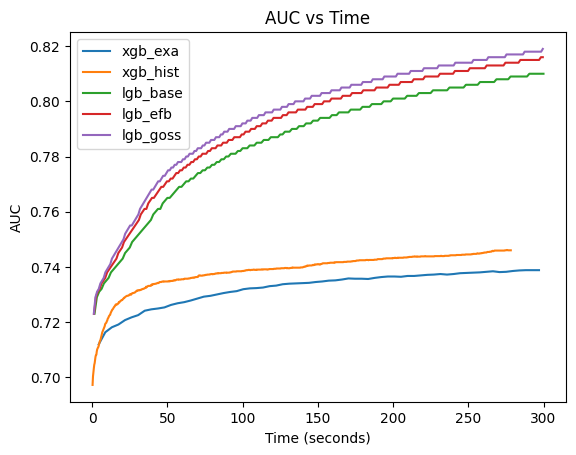

In [3]:
log_data=parse_log()

names=['xgb_exa','xgb_hist','lgb_base','lgb_efb','lgb_goss']

import matplotlib.pyplot as plt

# max x axis=1000
plt.figure()
plt.xlabel('Time (seconds)')
plt.ylabel('AUC')
plt.title('AUC vs Time')



for i in range(5):
    # smoothing per 3 points
    x=log_data[i][0]
    y=log_data[i][1]
    # y=[np.mean(y[max(0,i-1):min(i+2,len(y))]) for i in range(len(y))]
    
    cutted_data=[(x[i],y[i]) for i in range(len(x)) if x[i]<300]

    

    plt.plot(*zip(*cutted_data))


plt.legend(names)


plt.show()
